### 1. Setup

* First, set up Python, `numpy`, and `matplotlib`.

In [1]:
# set up Python environment: numpy for numerical routines, and matplotlib for plotting
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from pylab import *
# display plots in this notebook
%matplotlib inline

# set display defaults
plt.rcParams['figure.figsize'] = (10, 10)        # large images
plt.rcParams['image.interpolation'] = 'nearest'  # don't interpolate: show square pixels
plt.rcParams['image.cmap'] = 'gray'  # use grayscale output rather than a (potentially misleading) color heatmap

* Load `caffe`.

In [2]:
# The caffe module needs to be on the Python path;
#  we'll add it here explicitly.
import sys
caffe_root = '/home/lingkun/caffe/'  # this file should be run from {caffe_root}/examples (otherwise change this line)
python_root = '/home/lingkun/caffe/python'
sys.path.insert(0, python_root)

import caffe
# If you get "No module named _caffe", either you have not built pycaffe or you have the wrong path.

* If needed, download the reference model ("CaffeNet", a variant of AlexNet).

In [3]:
import os
if os.path.isfile('/home/lingkun/myDevelopment/saliency/deepmodel/mymodel.caffemodel'):
    print 'saliency caffemodel found.'
else:
    print 'not found'

saliency caffemodel found.


In [4]:
def vis_square(data):
    """Take an array of shape (n, height, width) or (n, height, width, 3)
       and visualize each (height, width) thing in a grid of size approx. sqrt(n) by sqrt(n)"""
    
    # normalize data for display
    data = (data - data.min()) / (data.max() - data.min())
    
    # force the number of filters to be square
    n = int(np.ceil(np.sqrt(data.shape[0])))
    padding = (((0, n ** 2 - data.shape[0]),
               (0, 1), (0, 1))                 # add some space between filters
               + ((0, 0),) * (data.ndim - 3))  # don't pad the last dimension (if there is one)
    data = np.pad(data, padding, mode='constant', constant_values=1)  # pad with ones (white)
    # tile the filters into an image
    data = data.reshape((n, n) + data.shape[1:]).transpose((0, 2, 1, 3) + tuple(range(4, data.ndim + 1)))
    data = data.reshape((n * data.shape[1], n * data.shape[3]) + data.shape[4:])
    plt.imshow(data); plt.axis('off')

* Define a helper function for visualizing sets of rectangular heatmaps.

### 2. Load net and set up input preprocessing

* Set Caffe to CPU mode and load the net from disk.

In [5]:
caffe.set_mode_cpu()
# it seems you should change the path here
model_def = '/home/lingkun/myDevelopment/saliency/deepmodel/deep_net_deploy.prototxt'
#model_def = '/home/lingkun/myDevelopment/saliency/deepmodel/deep_net_deploy.prototxt'
model_weights = '/home/lingkun/myDevelopment/saliency/deepmodel/mymodel.caffemodel'
#model_weights = '/home/lingkun/myDevelopment/saliency/deepmodel/deep_net_model.caffemodel'

net = caffe.Net(model_def,      # defines the structure of the model
                model_weights,  # contains the trained weights
                caffe.TEST)     # use test mode (e.g., don't perform dropout)

* Set up input preprocessing. (We'll use Caffe's `caffe.io.Transformer` to do this, but this step is independent of other parts of Caffe, so any custom preprocessing code may be used).

    Our default CaffeNet is configured to take images in BGR format. Values are expected to start in the range [0, 255] and then have the mean ImageNet pixel value subtracted from them. In addition, the channel dimension is expected as the first (_outermost_) dimension.
    
    As matplotlib will load images with values in the range [0, 1] in RGB format with the channel as the _innermost_ dimension, we are arranging for the needed transformations here.

In [6]:
# load the mean ImageNet image (as distributed with Caffe) for subtraction
mu = np.load(caffe_root + 'python/caffe/imagenet/ilsvrc_2012_mean.npy')
mu = mu.mean(1).mean(1)  # average over pixels to obtain the mean (BGR) pixel values
print 'mean-subtracted values:', zip('BGR', mu)

# create transformer for the input called 'data'
transformer = caffe.io.Transformer({'data': net.blobs['data1'].data.shape})

transformer.set_transpose('data', (2,0,1))  # move image channels to outermost dimension
transformer.set_mean('data', mu)            # subtract the dataset-mean value in each channel
transformer.set_raw_scale('data', 255)      # rescale from [0, 1] to [0, 255]
transformer.set_channel_swap('data', (2,1,0))  # swap channels from RGB to BGR

mean-subtracted values: [('B', 104.0069879317889), ('G', 116.66876761696767), ('R', 122.6789143406786)]


### 3. CPU classification

* Now we're ready to perform classification. Even though we'll only classify one image, we'll set a batch size of 50 to demonstrate batching.

In [7]:
# set the size of the input (we can skip this if we're happy
#  with the default; we can also change it later, e.g., for different batch sizes)
net.blobs['data1'].reshape(10,        # batch size
                          3,         # 3-channel (BGR) images
                          240, 320)  # image size is (3,240,320)

* Load an image (that comes with Caffe) and perform the preprocessing we've set up.

(480, 640, 3)
(3, 240, 320)


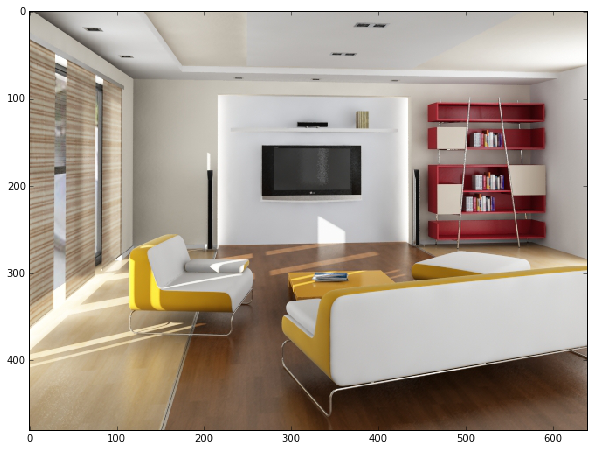

In [49]:
image = caffe.io.load_image('/home/lingkun/Desktop/11_ori.jpg')
height,width = image.shape[:2]
transformed_image = transformer.preprocess('data', image)
plt.imshow(image)
print image.shape[0:]
print transformed_image.shape[0:]

In [31]:
new_image = transformed_image.transpose(1, 2, 0)

(-0.5, 641.5, 481.5, -0.5)

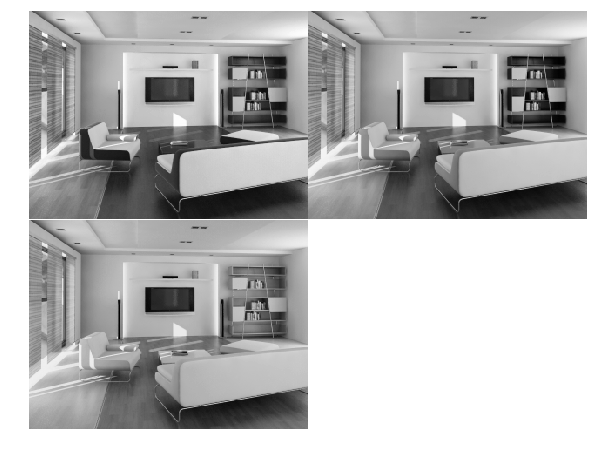

In [32]:
temp = transformed_image
temp = (temp - temp.min()) / (temp.max() - temp.min())
# force the number of filters to be square
n = int(np.ceil(np.sqrt(temp.shape[0])))
padding = (((0, n ** 2 - temp.shape[0]),
           (0, 1), (0, 1))                 # add some space between filters
           + ((0, 0),) * (temp.ndim - 3))  # don't pad the last dimension (if there is one)
temp = np.pad(temp, padding, mode='constant', constant_values=1)  # pad with ones (white)
# tile the filters into an temp
temp = temp.reshape((n, n) + temp.shape[1:]).transpose((0, 2, 1, 3) + tuple(range(4, temp.ndim + 1)))
temp = temp.reshape((n * temp.shape[1], n * temp.shape[3]) + temp.shape[4:])
plt.imshow(temp); plt.axis('off')

* Adorable! Let's classify it!

In [33]:
# copy the image data into the memory allocated for the net
net.blobs['data1'].data[...] = transformed_image

### perform classification
output = net.forward()

#output_prob = output['deconv1'][0]  # the output probability vector for the first image in the batch

#print 'predicted class is:', output_prob.argmax()
#print output['deconv1'][0]

### 5. Examining intermediate output

* A net is not just a black box; let's take a look at some of the parameters and intermediate activations.

First we'll see how to read out the structure of the net in terms of activation and parameter shapes.

* For each layer, let's look at the activation shapes, which typically have the form `(batch_size, channel_dim, height, width)`.

    The activations are exposed as an `OrderedDict`, `net.blobs`.

In [34]:
# for each layer, show the output shape
for layer_name, blob in net.blobs.iteritems():
    print layer_name + '\t' + str(blob.data.shape)

data1	(10, 3, 240, 320)
conv1	(10, 96, 240, 320)
norm1	(10, 96, 240, 320)
pool1	(10, 96, 120, 160)
conv2	(10, 256, 120, 160)
pool2	(10, 256, 60, 80)
conv3	(10, 512, 60, 80)
conv4	(10, 512, 60, 80)
conv5	(10, 512, 60, 80)
conv6	(10, 256, 60, 80)
conv7	(10, 128, 60, 80)
conv8	(10, 32, 60, 80)
conv9	(10, 1, 60, 80)
deconv1	(10, 1, 240, 320)


* Now look at the parameter shapes. The parameters are exposed as another `OrderedDict`, `net.params`. We need to index the resulting values with either `[0]` for weights or `[1]` for biases.

    The param shapes typically have the form `(output_channels, input_channels, filter_height, filter_width)` (for the weights) and the 1-dimensional shape `(output_channels,)` (for the biases).

In [35]:
for layer_name, param in net.params.iteritems():
    print layer_name + '\t' + str(param[0].data.shape)#, str(param[1].data.shape)

conv1	(96, 3, 7, 7)
conv2	(256, 96, 5, 5)
conv3	(512, 256, 3, 3)
conv4	(512, 512, 5, 5)
conv5	(512, 512, 5, 5)
conv6	(256, 512, 7, 7)
conv7	(128, 256, 11, 11)
conv8	(32, 128, 11, 11)
conv9	(1, 32, 13, 13)
deconv1	(1, 1, 8, 8)


* First we'll look at the first layer filters, `conv1`

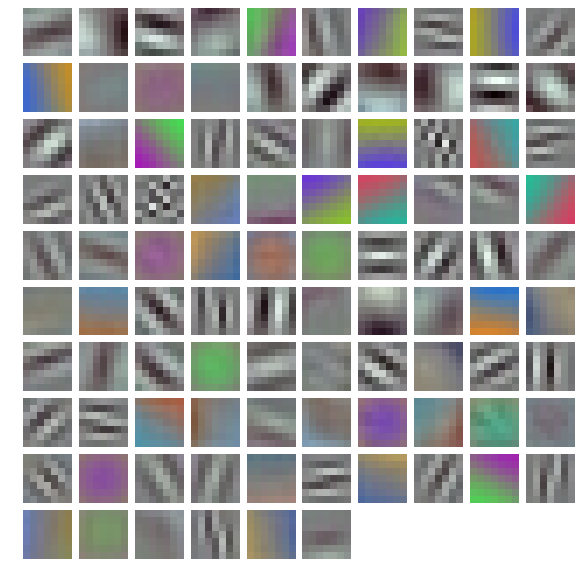

In [37]:
# the parameters are a list of [weights, biases]
filters = net.params['conv1'][0].data
vis_square(filters.transpose(0, 2, 3, 1))

* The first layer output, `conv1` (rectified responses of the filters above, first 36 only)

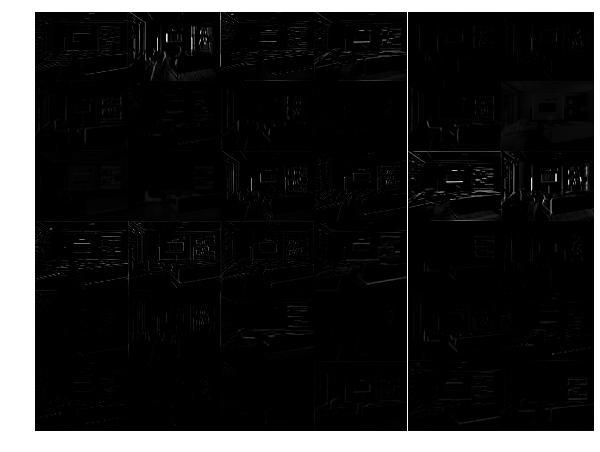

In [38]:
feat = net.blobs['conv1'].data[0, :36]
vis_square(feat)

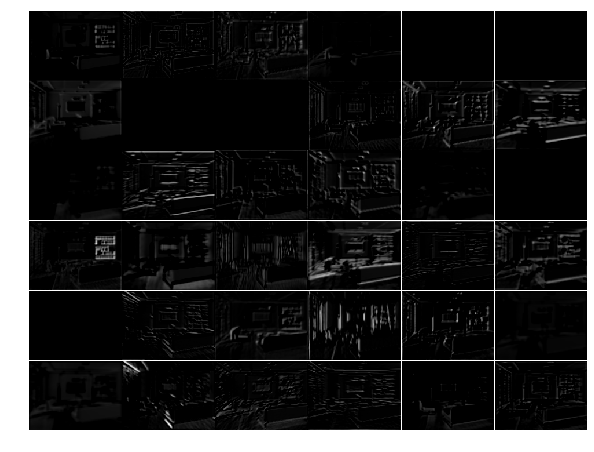

In [39]:
feat = net.blobs['conv2'].data[0, :36]
vis_square(feat)

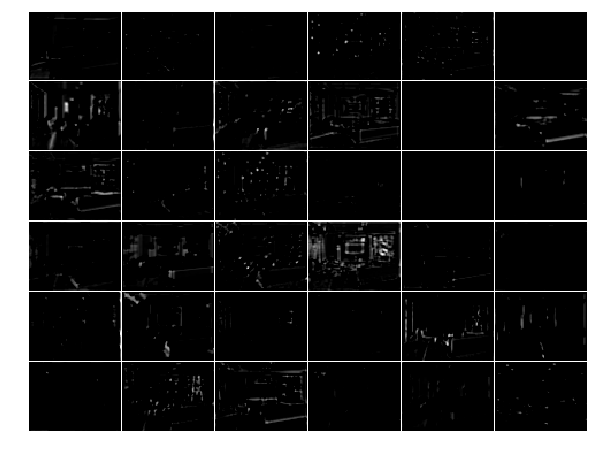

In [40]:
feat = net.blobs['conv3'].data[0, :36]
vis_square(feat)

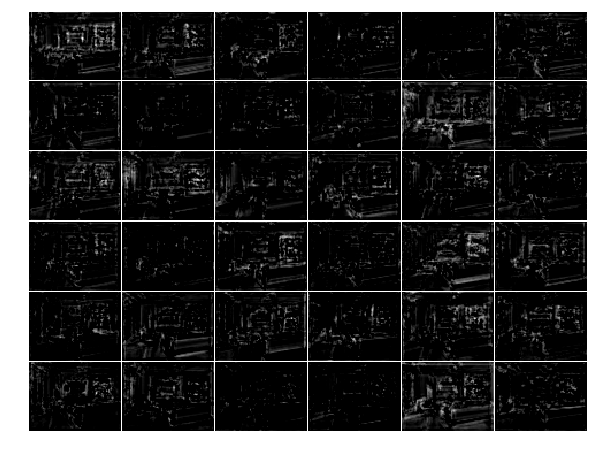

In [41]:
feat = net.blobs['conv4'].data[0, :36]
vis_square(feat)

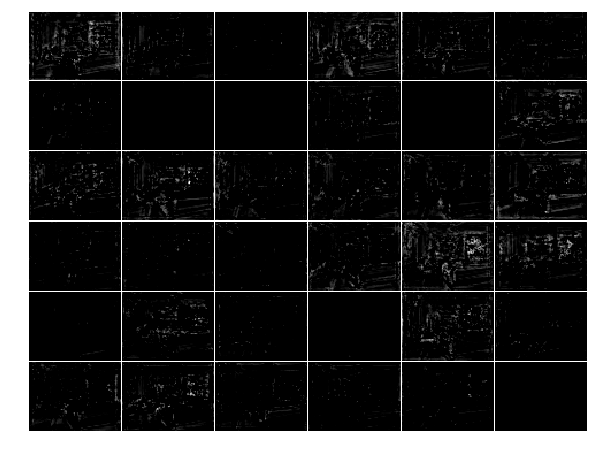

In [42]:
feat = net.blobs['conv5'].data[0, :36]
vis_square(feat)

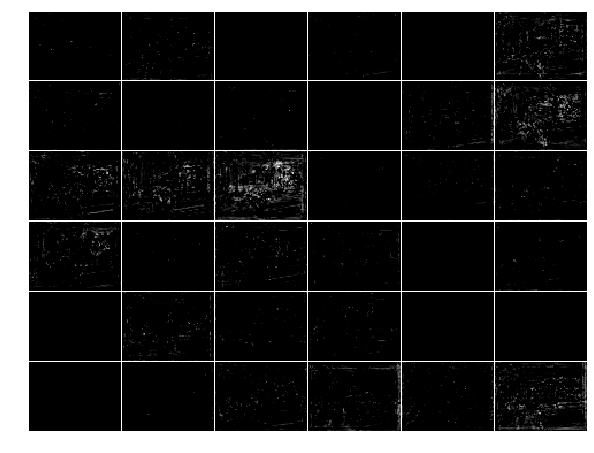

In [43]:
feat = net.blobs['conv6'].data[0, :36]
vis_square(feat)

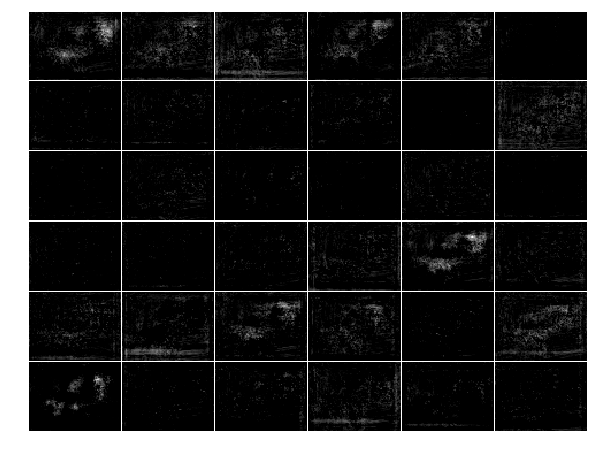

In [44]:
feat = net.blobs['conv7'].data[0, :36]
vis_square(feat)

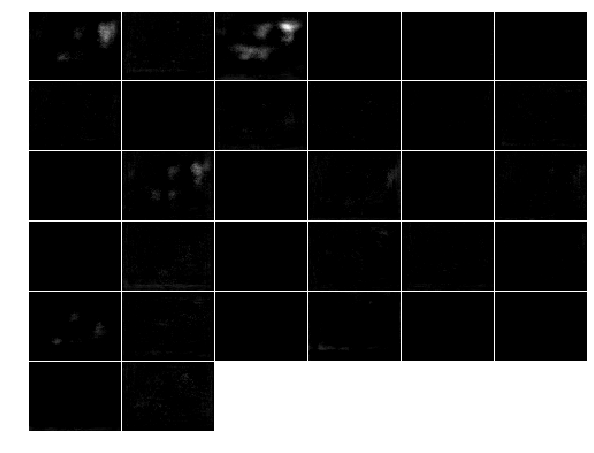

In [45]:
feat = net.blobs['conv8'].data[0, :36]
vis_square(feat)

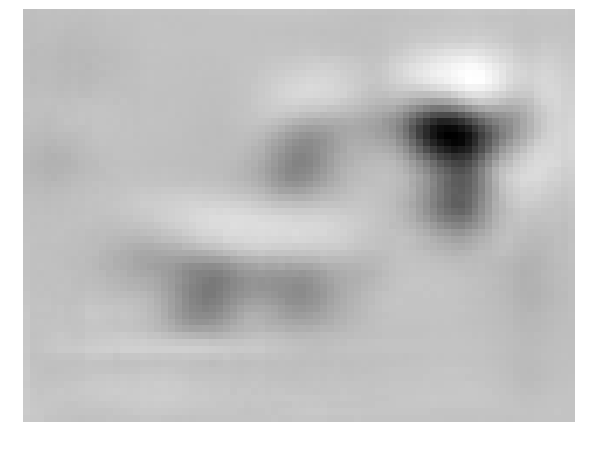

In [46]:
feat = net.blobs['conv9'].data[0, :36]
vis_square(feat)

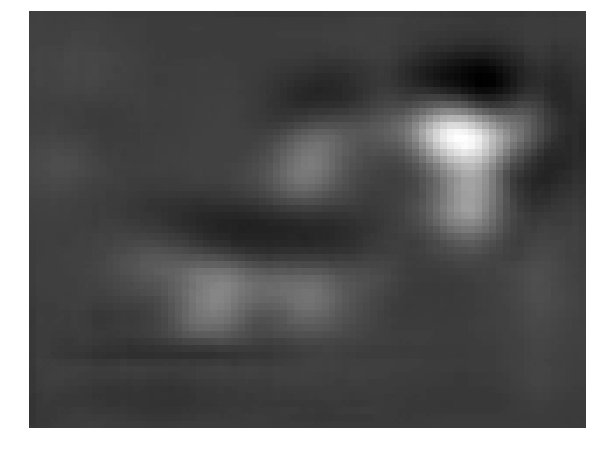

In [47]:
feat = net.blobs['deconv1'].data[0, :36]
vis_square(feat)

### 6. Try your own image

Now we'll grab an image from the web and classify it using the steps above.

* Try setting `my_image_url` to any JPEG image URL.

height: 327
width: 244
(327, 244, 3)


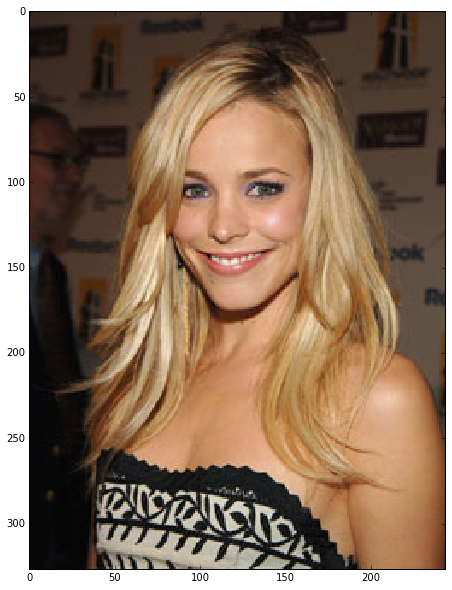

In [15]:
# download an image
my_image_url = "http://img22.mtime.cn/up/2011/02/20/144923.30519816_o.jpg"  # paste your URL here
!wget -O image.jpg $my_image_url

# transform it and copy it into the net
image = caffe.io.load_image('image.jpg')
# image = array(Image.open('/home/lingkun/Desktop/new_ori.jpg'))
plt.imshow(image)
#plt.imsave('/home/lingkun/Desktop/new_ori.jpg',image)
height,width = image.shape[:2]
print 'height:',height
print 'width:',width
print image.shape

In [16]:
transformed_image = transformer.preprocess('data', image)
net.blobs['data1'].data[...] = transformer.preprocess('data', image)

# perform forward
net.forward()
# obtain the output img
# feat = net.blobs['deconv1'].data[0, :36]
# print feat.shape[0:2]
# vis_square(feat)

{'deconv1': array([[[[-0.54856503, -0.55295861, -0.6562444 , ..., -0.04946508,
           -0.02423812, -0.02404477],
          [-0.55376703, -0.55818927, -0.66438597, ..., -0.05040884,
           -0.02446795, -0.02427309],
          [-0.69078493, -0.69855958, -0.76039851, ..., -0.03724166,
            0.02728431,  0.02628424],
          ..., 
          [-0.12326355, -0.12441097, -0.12942494, ...,  0.23066331,
            0.22005515,  0.21764332],
          [-0.11233253, -0.11323755, -0.0919316 , ...,  0.24255501,
            0.1766258 ,  0.17521194],
          [-0.1112624 , -0.11216217, -0.0914738 , ...,  0.23901333,
            0.17495438,  0.17355007]]],
 
 
        [[[-0.54856503, -0.55295861, -0.6562444 , ..., -0.04946508,
           -0.02423812, -0.02404477],
          [-0.55376703, -0.55818927, -0.66438597, ..., -0.05040884,
           -0.02446795, -0.02427309],
          [-0.69078493, -0.69855958, -0.76039851, ..., -0.03724166,
            0.02728431,  0.02628424],
          ...

(240, 320, 1)
240 320


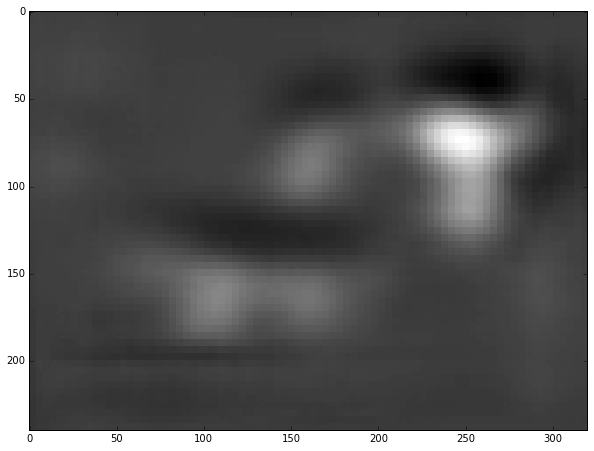

In [50]:
print net.blobs['deconv1'].data[0].transpose(1, 2, 0).shape
picture_klk = net.blobs['deconv1'].data[0].transpose(1, 2, 0)
x,y,z = picture_klk.shape
print x,y
klk_save_pic = np.zeros((x,y),dtype = float32)
#rotate the picture
for i in range(x):
    for j in range(y):
        klk_save_pic[i][j] = picture_klk[i][j][0]
#klk_save_pic = klk_save_pic.resize((height,width))
plt.imshow(klk_save_pic)
plt.imsave('/home/lingkun/Desktop/mid.jpg',klk_save_pic)
Image.open('/home/lingkun/Desktop/mid.jpg').resize((width,height)).save('/home/lingkun/Desktop/new.jpg')

(240, 320, 1)
<type 'numpy.float32'>


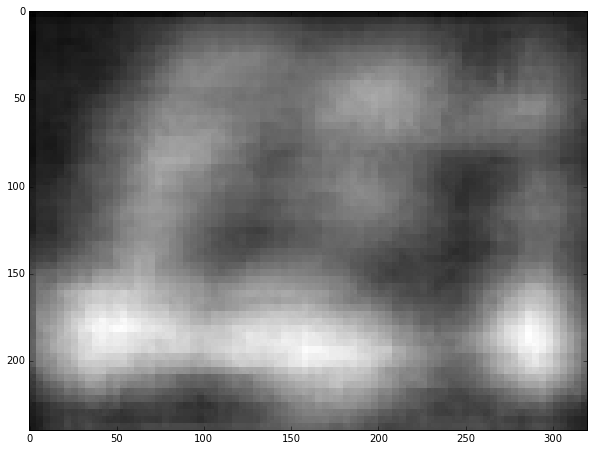

In [13]:
print net.blobs['deconv1'].data[0].transpose(1, 2, 0).shape
print type(net.blobs['deconv1'].data[0].transpose(1, 2, 0)[0][0][0])
picture_klk = net.blobs['deconv1'].data[0].transpose(1, 2, 0)
x,y,z = picture_klk.shape
klk_save_pic = np.zeros((x,y),dtype=np.float32)
for i in range(x):
    for j in range(y):
        klk_save_pic[i][j] = picture_klk[i][j][0]
plt.imshow(klk_save_pic)
plt.imsave('/home/lingkun/Desktop/mid.jpg',klk_save_pic)
Image.open('/home/lingkun/Desktop/mid.jpg').resize((width,height)).save('/home/lingkun/Desktop/new.jpg')